<a href="https://colab.research.google.com/github/kinaya18/Deep-Learning/blob/main/Week8-16/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 2: End-to-End Machine Learning Project**

Proyek ini bertujuan membangun sistem Machine Learning dari awal hingga akhir. Buku menggunakan California Housing Dataset teks tebaldari tahun 1990 untuk memprediksi harga rumah. Dataset ini mencakup informasi seperti lokasi, jumlah kamar, dan pendapatan.

In [1]:
import os
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

Setelah file diunduh, kita bisa membaca file CSV-nya:

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Menjelajahi Data Secara Singkat**

Tujuannya adalah mengenal struktur data: tipe data, missing values, distribusi, dll.

In [4]:
housing.info()
housing["ocean_proximity"].value_counts()
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Visualisasi distribusi setiap fitur:

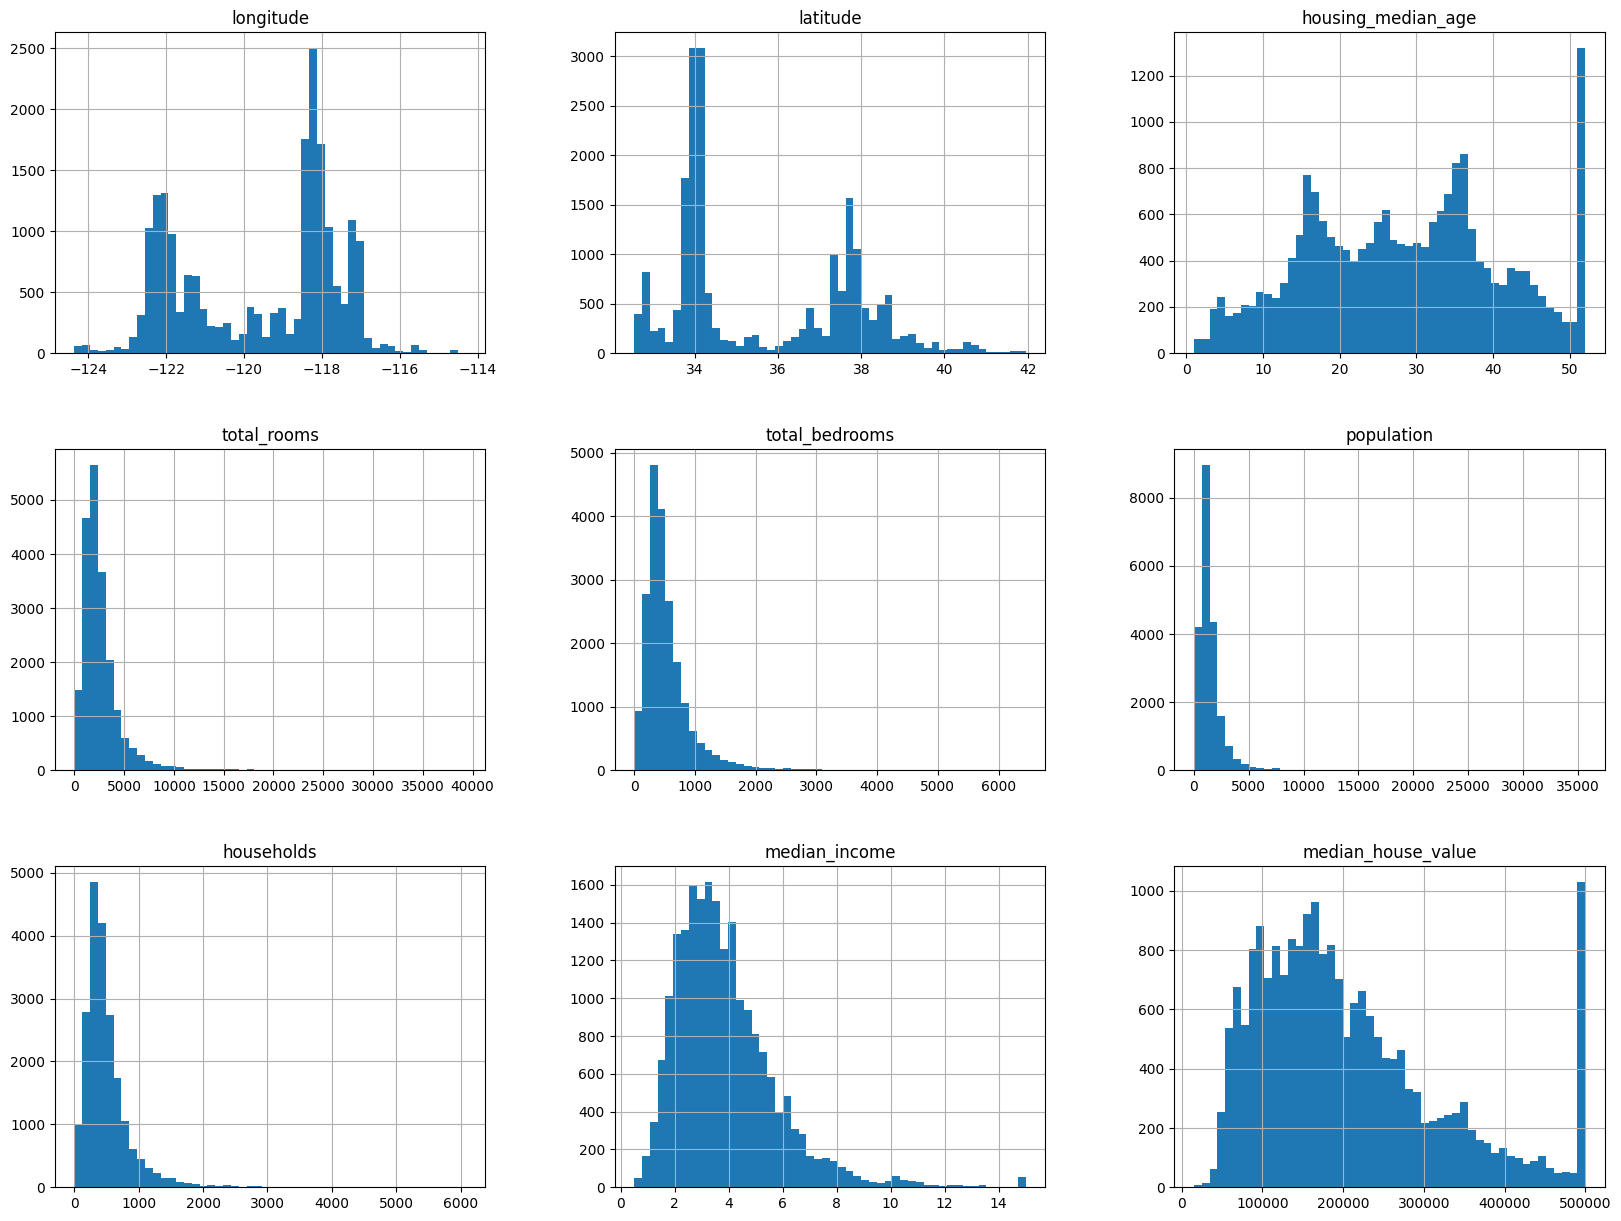

In [5]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

**Membuat Set Pengujian**

Untuk menghindari _data leakage_, kita pisahkan sebagian data untuk evaluasi:

In [6]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Namun, kita bisa membuat set pengujian yang lebih _stratified_ berdasarkan kolom `median_income`, karena pendapatan sangat memengaruhi harga rumah:

In [7]:
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])

<Axes: >

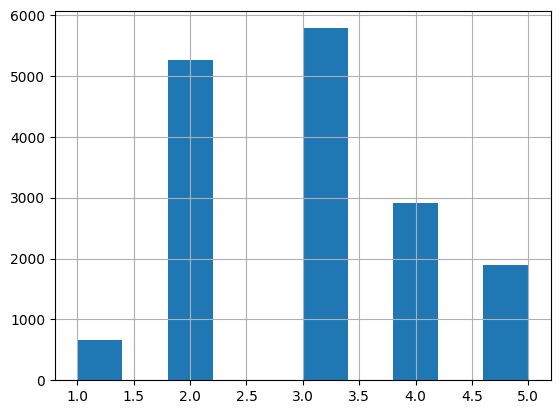

In [51]:
housing["income_cat"].hist()

Lalu gunakan `StratifiedShuffleSplit`:

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [52]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


**Visualisasi Geografis**

Karena data mencakup lokasi (`longitude`, `latitude`), kita bisa membuat visualisasi geografis:

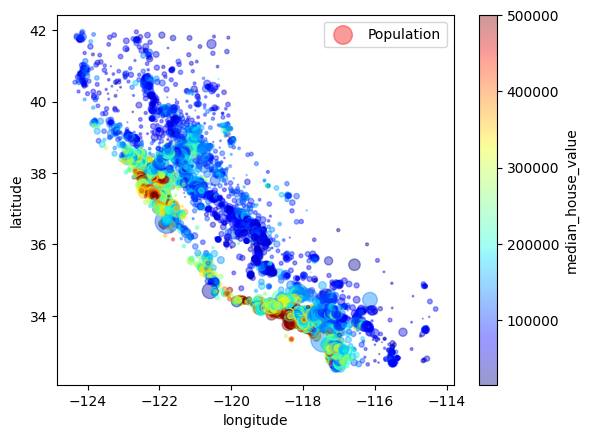

In [9]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"] / 100, label="Population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

**Korelasi Antar Fitur**

Kita ingin tahu fitur mana yang paling memengaruhi harga rumah:

In [11]:
# Menghitung matriks korelasi
corr_matrix = housing.corr(numeric_only=True)

# Korelasi dengan median_house_value
print("Correlation with 'median_house_value':")
print(corr_matrix["median_house_value"].sort_values(ascending=False))

Correlation with 'median_house_value':
median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


Visualisasi scatter fitur teratas:

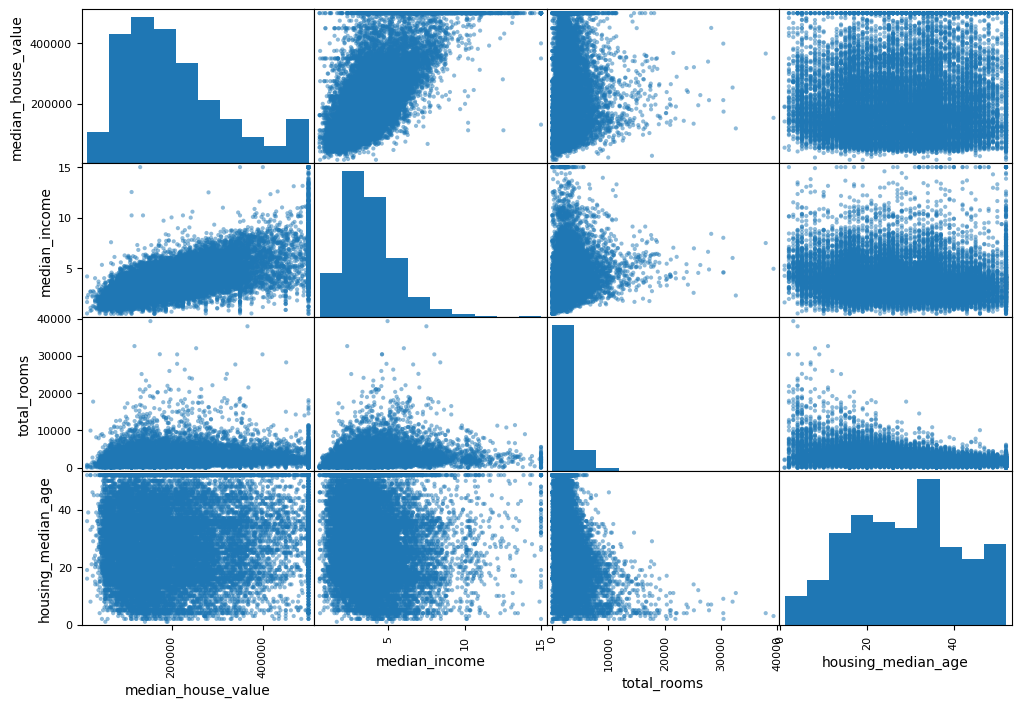

In [12]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()


Median income vs median house value scatter plot:


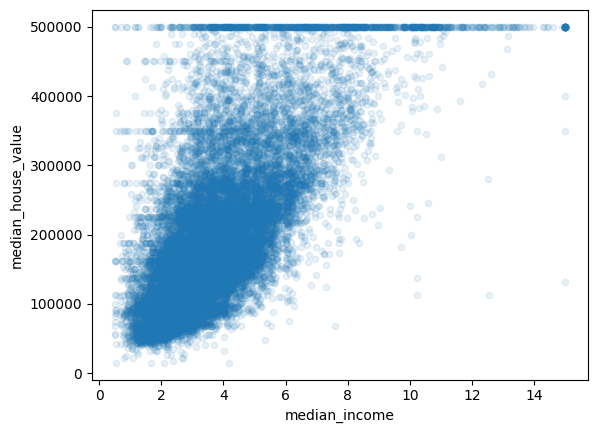

In [13]:
print("\nMedian income vs median house value scatter plot:")
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.show()

In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

**Persiapan Data untuk ML**

Kita pisahkan fitur dan label:

In [14]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [29]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [30]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155,    3.     ])

In [32]:
X = imputer.transform(housing_num)

In [33]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)

**Membersihkan Nilai Kosong**

Beberapa entri memiliki nilai `total_bedrooms` kosong:

In [15]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)

In [26]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [27]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [28]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Menangani Atribut Kategorikal**

Fitur `ocean_proximity` adalah data kategorikal:

In [16]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing[["ocean_proximity"]])
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

**Pipeline Persiapan Data**

Langkah-langkah ini dapat digabung ke dalam pipeline:

In [17]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()),
])

housing_num_prepared = num_pipeline.fit_transform(housing_num)

Kita juga bisa membuat ColumnTransformer untuk menangani kolom numerik dan kategorikal sekaligus:

In [35]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

**Training Model**

Kita mulai dengan model Linear Regression:

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [36]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [37]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 87710.9184376  312666.78080576 148193.92872405 181973.84391033
 242269.47566914]


In [38]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


Evaluasi dengan RMSE:

In [20]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68866.78550087014


In [39]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [40]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

**Evaluasi Lanjutan: Cross-Validation**

Untuk menghindari overfitting pada training set:

In [21]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

69020.731895787


In [44]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

In [46]:
display_scores(rmse_scores)

Scores: [72098.22665202 65263.25382431 67474.73970669 69344.34356573
 66405.23454953 72763.65486499 70271.51498924 69326.8790595
 66674.88791569 70584.58383018]
Mean: 69020.731895787
Standard deviation: 2377.8463322927096


In [47]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)

In [48]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [49]:
display_scores(lin_rmse_scores)

Scores: [72098.22665202 65263.25382431 67474.73970669 69344.34356573
 66405.23454953 72763.65486499 70271.51498924 69326.8790595
 66674.88791569 70584.58383018]
Mean: 69020.731895787
Standard deviation: 2377.8463322927096


In [53]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

Evaluasi RMSE RandomForestRegressor

In [54]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("\nRandomForestRegressor RMSE on training set:", forest_rmse)


RandomForestRegressor RMSE on training set: 18337.634681213494


Cross-validation

In [55]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("\nRandomForestRegressor Cross-Validation Scores:")
display_scores(forest_rmse_scores)


RandomForestRegressor Cross-Validation Scores:
Scores: [51064.99480869 48789.73940199 45927.76182897 50484.4258024
 47423.88436836 49529.05170975 51740.73748477 48933.39968108
 47565.79656695 53197.79682773]
Mean: 49465.75884806895
Standard deviation: 2091.406675635901


### **Grid Search**

In [57]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [58]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [59]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [60]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

64156.37635252747 {'max_features': 2, 'n_estimators': 3}
56174.45041242423 {'max_features': 2, 'n_estimators': 10}
53909.02128030545 {'max_features': 2, 'n_estimators': 30}
61247.81349892289 {'max_features': 4, 'n_estimators': 3}
54480.02965219185 {'max_features': 4, 'n_estimators': 10}
51984.923339078225 {'max_features': 4, 'n_estimators': 30}
60456.3521478172 {'max_features': 6, 'n_estimators': 3}
53409.63624755017 {'max_features': 6, 'n_estimators': 10}
51539.982187305046 {'max_features': 6, 'n_estimators': 30}
59536.97023170143 {'max_features': 8, 'n_estimators': 3}
52978.654212336405 {'max_features': 8, 'n_estimators': 10}
50920.24077519073 {'max_features': 8, 'n_estimators': 30}
61906.07592848129 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55199.52583992893 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60764.9640087613 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53564.74673135368 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

**Menganalisis Model Terbaik dan Kesalahannya**

In [61]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.02970505e-01, 9.44090080e-02, 5.18236417e-02, 2.76821601e-02,
       2.97443838e-02, 3.82947424e-02, 2.59910139e-02, 3.50854974e-01,
       1.30219934e-01, 1.02795060e-02, 1.29076284e-01, 1.42769645e-04,
       2.34200248e-03, 6.16907605e-03])

In [62]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3508549735172035), 'median_income'),
 (np.float64(0.13021993354508474), 'income_cat'),
 (np.float64(0.1290762841318268), 'pop_per_hhold'),
 (np.float64(0.10297050468225334), 'longitude'),
 (np.float64(0.09440900800441779), 'latitude'),
 (np.float64(0.051823641744849755), 'housing_median_age'),
 (np.float64(0.03829474240892979), 'population'),
 (np.float64(0.029744383810760253), 'total_bedrooms'),
 (np.float64(0.027682160065473183), 'total_rooms'),
 (np.float64(0.025991013947090687), 'households'),
 (np.float64(0.010279505971192638), 'rooms_per_hhold'),
 (np.float64(0.006169076047510226), 'INLAND'),
 (np.float64(0.0023420024782536742), '<1H OCEAN'),
 (np.float64(0.000142769645153546), 'bedrooms_per_room')]

**Mengevaluasi Sistem Anda pada Set Uji**

In [64]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(48733.90049608939)

menghitung interval kepercayaan untuk kesalahan generalisasi menggunakan scipy.stats.t.interval():

In [65]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(),scale=stats.sem(squared_errors)))

array([46761.32252108, 50629.68330145])